# Data-Driven ML development usingn Lance

In this notebook we seek to show that:
1. Lance makes it easy to improve model performance without needing a bunch of extra tools
2. Lance can save you significant cost on labeling and storage
3. Lance is customizable so you can tailor insights to your dataset and use case.

We'll walk through a simplified classification model example using the [ImageNet 1K dataset](https://www.image-net.org/index.php) dataset with some pre-trained models. <br/>

First, a few basic setup

In [1]:
import lance
import duckdb
import torchvision
import torch
import pandas as pd
import pyarrow as pa

In [2]:
%load_ext sql
%sql duckdb:///:memory: --connection_arguments {"preload_extensions":["lance"],"config":{"allow_unsigned_extensions":true}}

{'preload_extensions': ['lance'], 'config': {'allow_unsigned_extensions': True}}


Download the dataset that we need (~10GB from S3)

In [3]:
NEED_DOWNLOAD = True  # Set this to False to skip downloading the data tarballs
USE_CACHE = True  # set this to False to re-compute model inference and embeddings results

In [4]:
if NEED_DOWNLOAD:
    !rm -rf /tmp/imagenet.lance.tar.gz # represents training data
    !rm -rf /tmp/out_of_sample.lance.tar.gz # represents out-of-sample data
    !rm -rf /tmp/model.tar.gz # cached inference and embeddings results

    !curl https://eto-public.s3.amazonaws.com/datasets/imagenet_1k/imagenet_1k.lance.tar.gz --output /tmp/imagenet.lance.tar.gz    
    !curl https://eto-public.s3.amazonaws.com/datasets/imagenet_1k/imagenet1k_20k.lance.tar.gz --output /tmp/out_of_sample.lance.tar.gz
    !curl https://eto-public.s3.amazonaws.com/datasets/imagenet_1k/model.tar.gz --output /tmp/model.tar.gz        

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6525M  100 6525M    0     0  38.9M      0  0:02:47  0:02:47 --:--:-- 43.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2281M  100 2281M    0     0  42.8M      0  0:00:53  0:00:53 --:--:-- 44.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  635M  100  635M    0     0  41.0M      0  0:00:15  0:00:15 --:--:-- 41.1M


In [5]:
# Unzip the tarballs to create a clean dataset
# this takes about a minute
!rm -rf /tmp/*.lance
!cd /tmp && tar -xvf imagenet.lance.tar.gz
!cd /tmp && tar -xvf out_of_sample.lance.tar.gz    
!cd /tmp && tar -xvf model.tar.gz    

imagenet_1k.lance/
imagenet_1k.lance/_versions/
imagenet_1k.lance/_versions/1.manifest
imagenet_1k.lance/data/
imagenet_1k.lance/data/e975c520-792f-4612-ba93-791a32237dc6_5.lance
imagenet_1k.lance/data/e975c520-792f-4612-ba93-791a32237dc6_2.lance
imagenet_1k.lance/data/e975c520-792f-4612-ba93-791a32237dc6_3.lance
imagenet_1k.lance/data/e975c520-792f-4612-ba93-791a32237dc6_0.lance
imagenet_1k.lance/data/e975c520-792f-4612-ba93-791a32237dc6_4.lance
imagenet_1k.lance/data/e975c520-792f-4612-ba93-791a32237dc6_1.lance
imagenet_1k.lance/_latest.manifest
imagenet1k_20k.lance/
imagenet1k_20k.lance/_versions/
imagenet1k_20k.lance/_versions/1.manifest
imagenet1k_20k.lance/data/
imagenet1k_20k.lance/data/900e47a5-26dc-4caa-9b2e-113918cc376e_1.lance
imagenet1k_20k.lance/data/900e47a5-26dc-4caa-9b2e-113918cc376e_2.lance
imagenet1k_20k.lance/data/900e47a5-26dc-4caa-9b2e-113918cc376e_0.lance
imagenet1k_20k.lance/_latest.manifest
resnet.lance/
resnet.lance/_versions/
resnet.lance/_versions/1.manifest


In [6]:
uri = "/tmp/imagenet_1k.lance"
ds = lance.dataset(uri)

Data is stored on disk (local, s3, gcs, etc) and no database/infra is needed

## Basic EDA with Lance

Lance supports a wide range of computational libraries and engines.<br/>
This makes it easy to do basic data exploration using say DuckDB or pandas.

In [7]:
%%sql

SELECT image_id, image_uri, name, label, split
FROM ds
WHERE name <> ''
USING SAMPLE 10

Took 0.01694345474243164


,image_id,image_uri,name,label,split
0,n04355933_900,https://eto-public.s3.amazonaws.com/datasets/i...,sunglass,836,train
1,n04483307_3652,https://eto-public.s3.amazonaws.com/datasets/i...,trimaran,871,train
2,n02730930_3686,https://eto-public.s3.amazonaws.com/datasets/i...,apron,411,train
3,n02100583_24713,https://eto-public.s3.amazonaws.com/datasets/i...,vizsla,211,train
4,n02105056_14675,https://eto-public.s3.amazonaws.com/datasets/i...,groenendael,224,train
5,ILSVRC2012_val_00001437,https://eto-public.s3.amazonaws.com/datasets/i...,cassette,481,val
6,n02110341_9176,https://eto-public.s3.amazonaws.com/datasets/i...,dalmatian,251,train
7,n02108089_17905,https://eto-public.s3.amazonaws.com/datasets/i...,boxer,242,train
8,n04004767_73,https://eto-public.s3.amazonaws.com/datasets/i...,printer,742,train


### Simple summary statistics

You can load Lance datasets into pandas

In [8]:
%%sql

SELECT split, count(*) as num_images
FROM ds
GROUP BY 1

Took 0.00962209701538086


,split,num_images
0,train,47041
1,val,4000
2,test,8638


### Check label distribution

Note the you can also work with Lance datasets using SQL

<AxesSubplot: xlabel='name'>

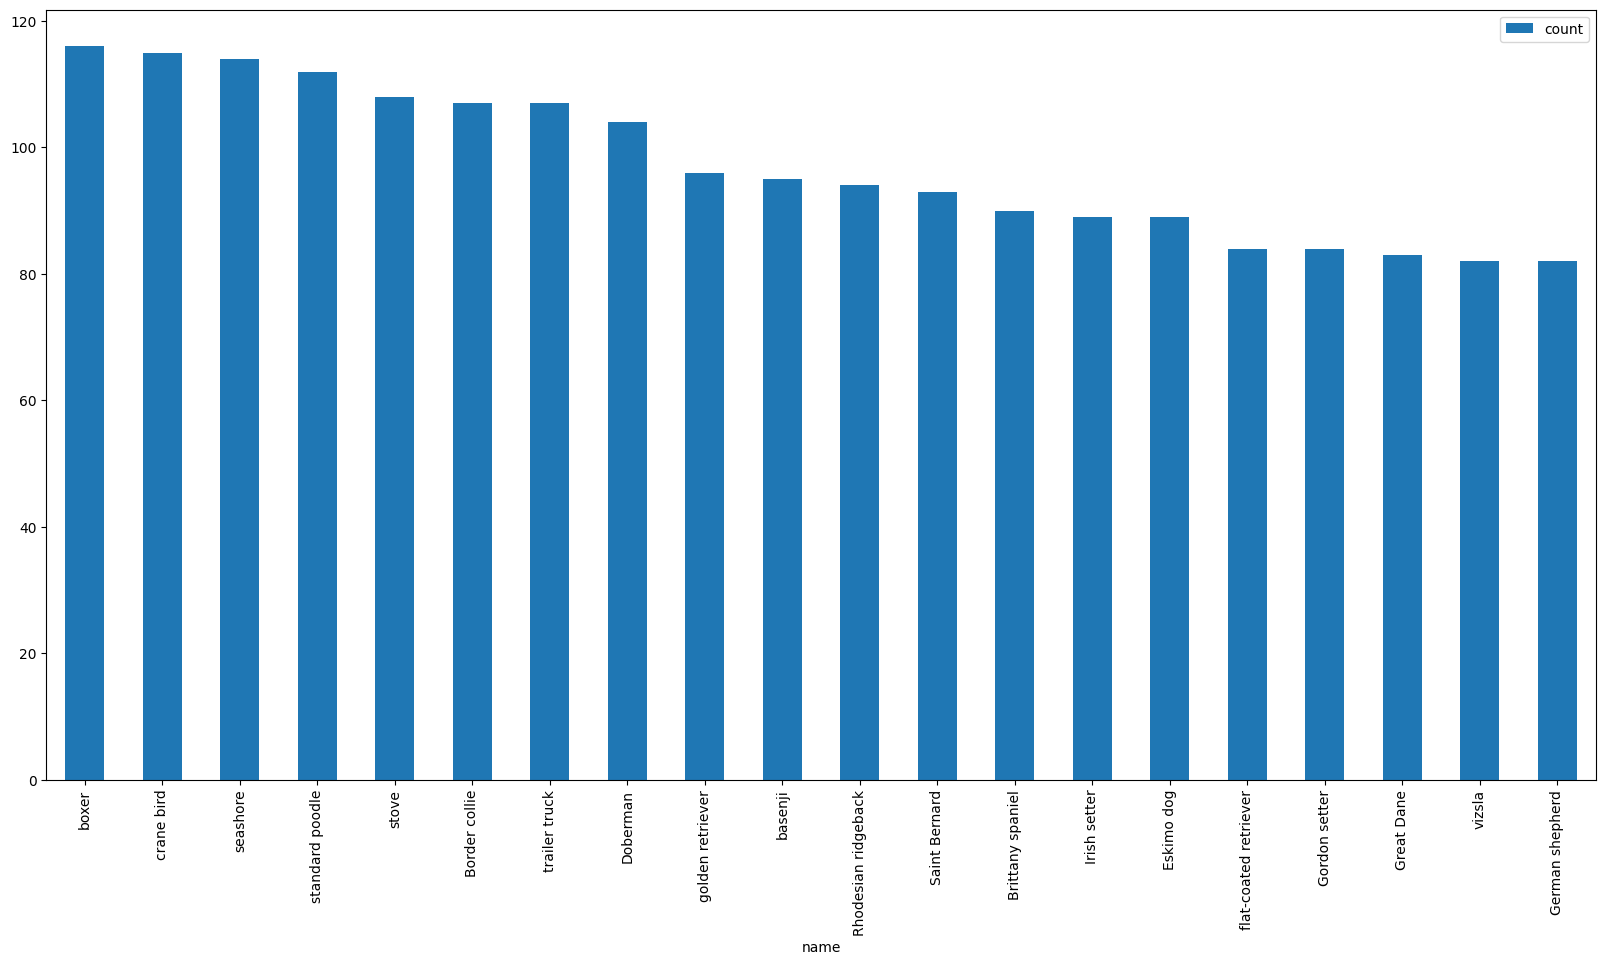

In [9]:
duckdb.query("""
SELECT name, count(image_id) as count 
FROM ds 
WHERE split != 'test'
GROUP BY 1
ORDER BY 2 DESC
LIMIT 20
""").to_df().set_index('name').plot.bar(figsize=(20, 10))

## Data insights with Lance

### 1. Model performance

Run Inference

We load two pretrained classic CNN and Transformer models to help us understand the dataset better.

* The ResNet model is based on the [Deep Residual Learning for Image Recognition paper](https://arxiv.org/abs/1512.03385)
* The VisionTransformer model is based on the [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale paper](https://arxiv.org/abs/2010.11929).

Models are moved to the accelerators (CUDA or MPS on MacOS) if available

In [10]:
from inference import run_model

resnet_table = run_model("resnet", uri, use_cache=USE_CACHE)
vit_table = run_model("vit", uri, use_cache=USE_CACHE)

Merge results back to the dataset on image_id

In [11]:
ds = ds.merge(resnet_table, left_on="image_id", right_on="image_id")
ds = ds.merge(vit_table, left_on="image_id", right_on="image_id")

### Compute ML metrics

Using SQL it's easy and fast to integrate Lance with BI tooling or visualization libraries to compute and visualize ML metrics

For example, it would be simple to generate SQL to compute model precision

In [12]:
%%sql 

SELECT
  split,
  SUM(CAST(resnet.label = ds.label  AS FLOAT)) / COUNT(ds.label) as resnet,
  SUM(CAST(vit.label = ds.label AS FLOAT)) / COUNT(ds.label) as vit
FROM ds
WHERE split <> 'test'
GROUP BY 1

Took 0.018757343292236328


,split,resnet,vit
0,train,0.92007,0.943539
1,val,0.81350,0.814750


This matches with published stats and, on the surface, have similar performance between the two models on the validation set

### Digging into arbitrary slices

But actually, there are subtle differences that become apparent once we dig into it

Here we can see a bunch of categories that vit is bettter than resnet on

In [13]:
%%sql precision_by_class <<

SELECT
  ds.name,
  SUM(CAST(resnet.label = ds.label AS FLOAT)) / COUNT(ds.label) as resnet,
  SUM(CAST(vit.label = ds.label AS FLOAT)) / COUNT(ds.label) as vit
FROM ds
WHERE split = 'val'
GROUP BY 1
ORDER BY resnet ASC

Took 0.019188404083251953


,name,resnet,vit
0,packet,0.0,0.25
1,water jug,0.0,0.00
2,wine bottle,0.0,0.25
3,cup,0.0,0.00
4,tiger cat,0.0,0.00
...,...,...,...
994,ibex,1.0,1.00
995,marmot,1.0,1.00
996,German shepherd,1.0,1.00
997,mortar,1.0,1.00


<AxesSubplot: xlabel='name'>

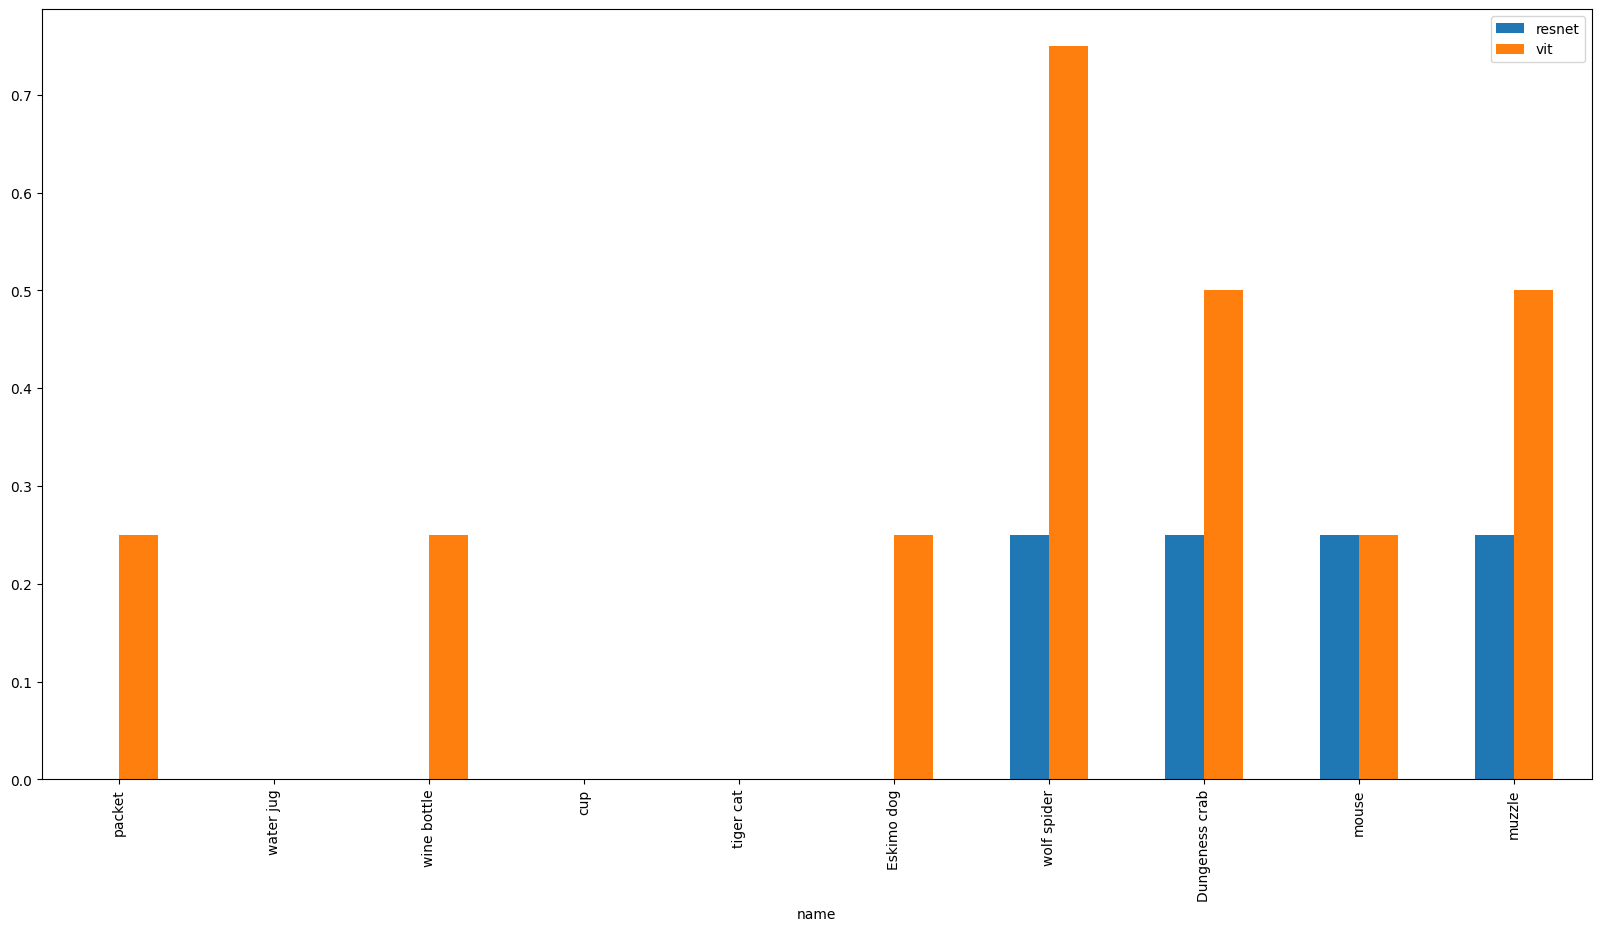

In [14]:
precision_by_class.head(10).set_index('name').plot.bar(figsize=(20,10))

<div class="alert alert-block alert-warning"> 
    Can you modify the SQL query above to show categories where resnet outperforms vit?
</div>

### Confusion matrix

For model iteration, we often want to analyze what we get wrong

In [15]:
%%sql label_names <<

SELECT DISTINCT label, name
FROM ds
WHERE split='val'
ORDER BY label

Took 0.015139341354370117


,label,name
0,0,tench
1,1,goldfish
2,2,great white shark
3,3,tiger shark
4,4,hammerhead
...,...,...
995,995,earthstar
996,996,hen-of-the-woods
997,997,bolete
998,998,ear


In [16]:
%%sql confusion <<

SELECT ds.name as gt, label_names.name as resnet
FROM ds, label_names
WHERE split = 'val' and resnet.label=label_names.label

Took 0.020267724990844727


,gt,resnet
0,tench,tench
1,goldfish,goldfish
2,hammerhead,great white shark
3,electric ray,tiger shark
4,hammerhead,hammerhead
...,...,...
3995,swab,swab
3996,racer,racer
3997,racer,racer
3998,racer,racer


In [17]:
rs = confusion.reset_index().groupby(['gt', 'resnet']).count().reset_index().rename(columns={'index': 'count'})

In [18]:
rs["pct"] = rs.groupby("gt", group_keys=False)["count"].apply(lambda grp: grp / grp.sum())

<AxesSubplot: xlabel='gt', ylabel='resnet'>

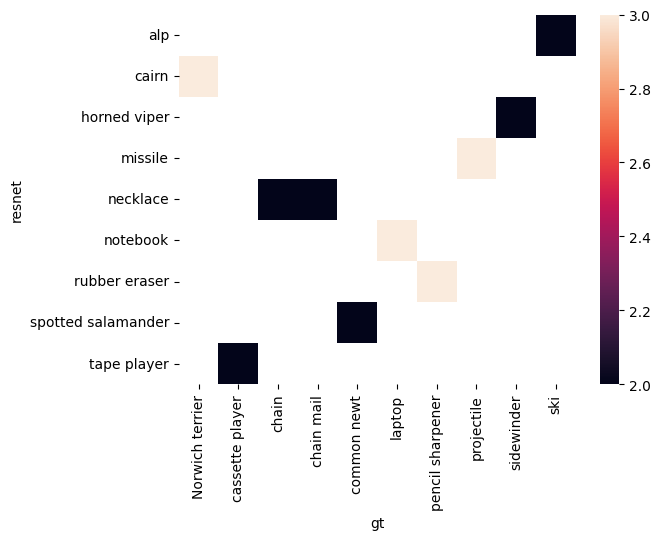

In [19]:
import seaborn as sns

sns.heatmap((rs[rs["gt"] != rs["resnet"]]
             .sort_values("pct", ascending=False).head(10)
             .set_index(["gt", "resnet"])["count"].unstack("gt")))

<div class="alert alert-block alert-info"> 
    💡 INSIGHT: top confused classes are often very similar. We can focus on these categories to improve model performance much more efficiently than adding data using random sampling
</div>

### 2. Automatically Detecting Mislabels

Sometimes it's not the model but the labels that are wrong. Even a few bad labels can have outsized impact on model accuracy so it's critical we find them. To find potential mislables, we first need to automately establish a baseline of what consider as correct labels.

We establish the baseline via the agreements of the two pre-trained models inference results. That is,
if the two models strongly agree with each other (i.e., same label and confience score is high), but the predict label is not what ground truth describes.

Such logic can be easily expressed via SQL:

In [20]:
%%sql --lance

SELECT ds.image_id,
       ds.image_uri,
       ds.name AS ground_truth,
       label_names.name as predict,
       resnet.score as score
FROM ds, label_names
WHERE
  split = 'train'
  AND ds.label !=  resnet.label 
  AND resnet.label = vit.label
  AND resnet.label = label_names.label
ORDER BY resnet.score DESC
LIMIT 20

Took 0.02861809730529785


For example, one might easily argue the following are misclassified by the annotaters

- n02950826_5479 has "cannon" as gt and "tank" as the model prediction
- n04357314_14489 has "sunscreen" as gt and "bikini" as the model prediction
- n03041632_3926 has "cleaver" as gt and "butcher shop" as the model prediction
- n02807133_8732 has "bathing cap" as gt and "maillot tank suit" as the model prediction


As we encounter more long-tail problems, it's easy to run additional models to build clustered predictions to improve signal-to-noise ratio

### 3. Active Learning with Lance

The last data insight we'll show is how to use Lance to do active learning. <br/>
With active learning, we can get significantly better model performance on fewer labels. <br/>

One typical approach of Active Learning is finding `Lowest Margin of Confidence`. 

This query finds the examples where a model (*ResNet* in this case) is less confident between the top two candidates.

In [21]:
%%sql least_margin <<

SELECT    
    ds.image_id,
    ds.image_uri,
    n1.name as best_guess,
    n2.name as second_guess,
    resnet.score - resnet.second_score AS margin_of_confidence
FROM ds, label_names as n1, label_names as n2
WHERE 
    split != 'test'
    AND n1.label = resnet.label
    AND n2.label = resnet.second_label
ORDER BY margin_of_confidence
LIMIT 10

Took 0.054139137268066406


,image_id,image_uri,best_guess,second_guess,margin_of_confidence
0,n03775546_8963,https://eto-public.s3.amazonaws.com/datasets/i...,mixing bowl,soup bowl,0.000007
1,n02395406_14804,https://eto-public.s3.amazonaws.com/datasets/i...,wild boar,hog,0.000021
2,n07614500_31111,https://eto-public.s3.amazonaws.com/datasets/i...,ice cream,chocolate sauce,0.000036
3,ILSVRC2012_val_00005477,https://eto-public.s3.amazonaws.com/datasets/i...,pencil sharpener,piggy bank,0.000042
4,n04041544_15634,https://eto-public.s3.amazonaws.com/datasets/i...,loudspeaker,Polaroid camera,0.000050
5,n01756291_12388,https://eto-public.s3.amazonaws.com/datasets/i...,horned viper,sidewinder,0.000083
6,n04579145_3324,https://eto-public.s3.amazonaws.com/datasets/i...,water jug,pitcher,0.000090
7,n02988304_6146,https://eto-public.s3.amazonaws.com/datasets/i...,CD player,radio,0.000116
8,ILSVRC2012_val_00048921,https://eto-public.s3.amazonaws.com/datasets/i...,pretzel,acorn squash,0.000158
9,n04517823_24477,https://eto-public.s3.amazonaws.com/datasets/i...,wig,hognose snake,0.000165


### Finding similar examples

Once we know these low confidence examples, we can find similar out-of-sample data to augment our training dataset using Lance's ML functions in DuckDB

Get out of sample data

Compute embeddings

In [22]:
from embeddings import compute_embeddings

uri_unlabeled = "/tmp/imagenet1k_20k.lance"
embeddings_unlabeled = compute_embeddings("unlabeled", "resnet", uri_unlabeled, use_cache=USE_CACHE)

embeddings_train = compute_embeddings("train", "resnet", uri, use_cache=USE_CACHE)

In [23]:
out_of_sample = lance.dataset(uri_unlabeled)
out_of_sample = out_of_sample.merge(embeddings_unlabeled, left_on="image_id", right_on="image_id")

training_set = lance.dataset(uri)
training_set = training_set.merge(embeddings_train, left_on="image_id", right_on="image_id")

### Lance has ML functions for duckdb to compute similarity

In [24]:
least_margin.iloc[2]

image_id                                                  n07614500_31111
image_uri               https://eto-public.s3.amazonaws.com/datasets/i...
best_guess                                                      ice cream
second_guess                                              chocolate sauce
margin_of_confidence                                             0.000036
Name: 2, dtype: object

In [25]:
%%sql --lance

with ref as (select embedding from training_set where image_id='n07614500_31111')

SELECT image_id, image_uri, l2_distance(oos.embedding, ref.embedding) as similarity
FROM out_of_sample oos cross join ref
ORDER BY 3
LIMIT 10

Took 1.8618309497833252


## Completing the loop

Once we pick out new training examples, we can use Lance to export these for labeling.
Then we can bring it back in for re-training, without having to copy or convert data manually

### Labeling integration

With Lance you can save labeling cost:
1. No need to pay label service to manage data points you'll never label
2. Data insights increases the efficiency of each label
3. Easy integration to open-source labeling tools like Label Studio

We'll use [Label Studio](https://labelstud.io/) here.
1. Install and start Label Studio
2. Create a new project called "lance", choose the "image classification" template
3. Add "ice cream" and "chocolate sauce" for the possible labels

In [26]:
from labelstudio import LanceLabelStudioClient as Client

# By default connect to localhost:8080 and relies on envvar LABEL_STUDIO_API_KEY for auth

ls = Client.create()
p = ls.get_project("lance")

In [27]:
p.add_tasks(sql_result_set.df.head(5), image_col="image_uri", pk_col="image_id")

[11, 12, 13, 14, 15]

Now go to Label Studio

Default is http://localhost:8080/

Once labeled, we merge the new labels back into the dataset

In [29]:
import pyarrow as pa
label_df = p.get_annotations("label_studio_labels")

schema = pa.schema([pa.field('id', pa.string()),
                    pa.field('label_studio_labels', pa.string())])
new_labels = pa.Table.from_pandas(label_df, schema)
new_labels.to_pandas()

,id,label_studio_labels
0,ILSVRC2012_val_00003592,ice cream
1,n07836838_14166,ice cream
2,n07836838_12552,chocolate sauce
3,n07836838_16510,ice cream
4,n07836838_12530,ice cream


In [30]:
%%sql new_rows <<

SELECT new_labels.id as image_id, 
       label_names.label,
       label_studio_labels as name,
       'train' as split,
       out_of_sample.image_uri,
       out_of_sample.image,
       null as resnet,
       null as vit,
       null as embedding
FROM out_of_sample, new_labels, label_names
WHERE out_of_sample.image_id = new_labels.id
  AND label_names.name = label_studio_labels

Took 0.9822747707366943


,image_id,label,name,split,image_uri,image,resnet,vit,embedding
0,ILSVRC2012_val_00003592,928,ice cream,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,None,None,None
1,n07836838_12552,960,chocolate sauce,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,None,None,None
2,n07836838_12530,928,ice cream,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,None,None,None
3,n07836838_16510,928,ice cream,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,None,None,None
4,n07836838_14166,928,ice cream,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,None,None,None


In [31]:
split_type = pd.CategoricalDtype(["train", "val", "test"])
new_rows["split"] = new_rows.split.astype(split_type)
new_rows_table = pa.Table.from_pandas(new_rows, schema=training_set.schema)
lance.write_dataset(new_rows_table, uri, mode="append")

### Retrain without copying or converting

Lance has native pytorch support so you can re-train the model without converting / copying the dataset into a pytorch compatible format

In [32]:
import pyarrow.compute as pc
from lance.pytorch.data import Dataset

dataset = Dataset(
    uri,
    filter=pc.field("split") == "train",
    columns=["image_id", "label", "image"],  # only read certain columns
    batch_size=1
)

for batch in dataset:
    print(batch)
    break

['ILSVRC2012_test_00085534', tensor(0), <PIL.Image.Image image mode=RGB size=500x375 at 0x7F459E5B7E80>]


## Versioning is automatic !

We've added columns and rows throughout this exercise. <br/>
Under the hood, Lance is keeping track of it automatically so you can always reproduce your work exactly

In [33]:
ds = lance.dataset(uri)
ds.versions()

[{'version': 1,
  'timestamp': datetime.datetime(2022, 12, 22, 19, 18, 59, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 2,
  'timestamp': datetime.datetime(2022, 12, 22, 23, 57, 26, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 3,
  'timestamp': datetime.datetime(2022, 12, 22, 23, 57, 26, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 4,
  'timestamp': datetime.datetime(2022, 12, 23, 0, 12, 26, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 5,
  'timestamp': datetime.datetime(2022, 12, 23, 0, 43, 18, tzinfo=datetime.timezone.utc),
  'metadata': {}}]

We can use an older version via `checkout`

In [34]:
v1 = ds.checkout(1)

In [35]:
%%sql

SELECT * FROM v1
LIMIT 10

Took 1.9840376377105713


,image_id,label,name,split,image_uri,image
0,n01665541_15180,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1,n01665541_9924,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
2,n01665541_14866,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
3,n01665541_3735,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
4,n01665541_12069,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
5,n01665541_89,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
6,n01665541_13935,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
7,n01665541_1777,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
8,n01665541_14349,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
9,n01665541_12409,34,leatherback turtle,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...


## Data diff'ing is also free !

In [36]:
diff = lance.diff(ds, 1, 5)
diff

LanceDiff
  Added: 5 rows, 9 columns

In [37]:
diff.columns_added().schema

resnet.label: int64
resnet.score: double
resnet.second_label: int64
resnet.second_score: double
vit.label: int64
vit.score: double
vit.second_label: int64
vit.second_score: double
embedding: fixed_size_list<item: float>[2048]
  child 0, item: float

In [38]:
tbl = diff.rows_added("image_id").head()

In [39]:
%%sql

SELECT * FROM tbl

Took 0.005789756774902344


,image_id,label,name,split,image_uri,image,resnet,vit,embedding
0,ILSVRC2012_val_00003592,928,ice cream,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,n07836838_12552,960,chocolate sauce,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,n07836838_12530,928,ice cream,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,n07836838_16510,928,ice cream,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,n07836838_14166,928,ice cream,train,https://eto-public.s3.amazonaws.com/datasets/i...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Lance makes it super-simple to create a Data-Driven ML development loop

- Get insights in under 100ms via duckdb or pandas

- Save labeling cost massively

- Tailor insights queries to your use case

- Version and diff data with zero copying and zero effort